# LSTM model - half of hour step

Libraries import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from different_functions import transform_and_split_data, LSTM_model, transform_and_split_data, make_predictions

CSV file reading

In [3]:
# Read the CSV file
all_data = pd.read_csv("data_for_main_model/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes"]]

In [4]:
all_data.head()

,relh,skph,temp,minutes
0,100.0,0.000,-2.0,0
1,100.0,0.000,-2.0,30
2,100.0,3.704,-2.0,0
3,100.0,0.000,-2.0,30
4,100.0,5.556,-3.0,0


In [5]:
# every 30 min
all_data.drop('minutes',axis='columns', inplace=True)

MSE calculations for given window size and etc. for the next 1 to 3 hours then next 2, 4, 6 steps

In [6]:
def return_time(window_size,test_size,valid_size,epochs,learning_rate, save_model = False, batch_size = 32, shuffle = True, name_of_file = "lstm"):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    bias_relh = []
    bias_skph = []
    bias_temp = []

    # MSE calculations for given window size and etc. in next 1 to 3 next hours
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 6
    for hour in range(1,last_pred_hour,2): # cause every data timestamp is in 30 min distance
        # (hour == 1) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, hour) 
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size, batch_size, shuffle)

        ## save as binary file .pkl
        if(save_model):
            file_name = name_of_file + str(int((hour+1)/2)) + ".pkl"
            with open(file_name, "xb") as f_1:
                pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


        bias_relh.append(sum(pred[0] - actaul[0])/len(pred[0]))
        bias_skph.append(sum(pred[1] - actaul[1])/len(pred[0]))
        bias_temp.append(sum(pred[2] - actaul[2])/len(pred[0]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul, bias_relh, bias_skph, bias_temp

# Test for 6 and then 12 timestamps (3 and 6 hours)

In [7]:
# test_size = 0.15
# valid_size = 0.15
# epochs = 12
# learning_rate=0.001

# window_size = 6
# MSE_humid_6, MAE_humid_6, MSE_wind_6, MAE_wind_6, MSE_temp_6, MAE_temp_6, pred_6, actaul_6  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
# window_size = 12
# MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12  = return_time(window_size,test_size,valid_size,epochs,learning_rate)

In [8]:
# plt.plot(MAE_temp_6,'g')
# plt.plot(MAE_temp_12,'r')
# plt.title("MSE for different hours and models with different window size - temperature")
# plt.xlabel("hour")
# plt.ylabel("MSE")

In [9]:
# plt.plot(MAE_wind_6,'g')
# plt.plot(MAE_wind_12,'r')
# plt.title("MSE for different hours and models with different window size - wind")
# plt.xlabel("hour")
# plt.ylabel("MSE")

In [10]:
# plt.plot(MAE_humid_6,'g')
# plt.plot(MAE_humid_12,'r')
# plt.title("MSE for different hours and models with different window size - humid")
# plt.xlabel("hour")
# plt.ylabel("MSE")

###  Training data save

In [11]:
# # relh	 skph 	temp
# data = pd.DataFrame()
# data['MAE_humid_6'] = MAE_humid_6
# data['MAE_wind_6'] = MAE_wind_6
# data['MAE_temp_6'] = MAE_temp_6
# data['MAE_humid_12'] = MAE_humid_12
# data['MAE_wind_12'] = MAE_wind_12
# data['MAE_temp_12'] = MAE_temp_12

# data.to_csv("data_each_30_min")

# Models: 12 previous steps for 3 next hours predictions

In [12]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001
batch_size = 32

# with data shuffle
window_size = 12
MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12, bias_relh, bias_skph, bias_temp  = return_time(window_size,test_size,valid_size,epochs,learning_rate, True, batch_size, True)

# without data shuffle
window_size = 12
MSE_humid_12_ds, MAE_humid_12_ds, MSE_wind_12_ds, MAE_wind_12_ds, MSE_temp_12_ds, MAE_temp_12_ds, pred_12_ds, actaul_12_ds, bias_relh_ds, bias_skph_ds, bias_temp_ds  = return_time(window_size,test_size,valid_size,epochs,learning_rate, True, batch_size, False, "lstm_for_update")

Epoch 1/12
3154/3154 [==============================] - 22s 6ms/step - loss: 0.1213 - root_mean_squared_error: 0.3483 - val_loss: 0.0983 - val_root_mean_squared_error: 0.3135
Epoch 2/12
3154/3154 [==============================] - 20s 6ms/step - loss: 0.1083 - root_mean_squared_error: 0.3291 - val_loss: 0.0932 - val_root_mean_squared_error: 0.3052
Epoch 3/12
3154/3154 [==============================] - 21s 7ms/step - loss: 0.1068 - root_mean_squared_error: 0.3268 - val_loss: 0.0939 - val_root_mean_squared_error: 0.3064
Epoch 4/12
3154/3154 [==============================] - 21s 7ms/step - loss: 0.1062 - root_mean_squared_error: 0.3258 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3057
Epoch 5/12
3154/3154 [==============================] - 20s 6ms/step - loss: 0.1051 - root_mean_squared_error: 0.3241 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 6/12
3154/3154 [==============================] - 20s 6ms/step - loss: 0.1043 - root_mean_squared_error: 0.3230 - val_l

Text(0.5, 1.0, 'temperature')

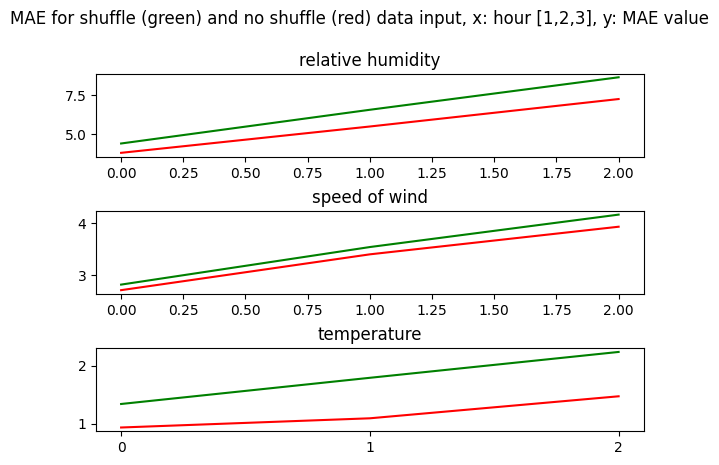

In [13]:
# with and without data shuffle
import matplotlib.ticker as mticker

fig, axs = plt.subplots(3)
fig.suptitle('MAE for shuffle (green) and no shuffle (red) data input, x: hour [1,2,3], y: MAE value')
fig.tight_layout(pad=1.8)
fig.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

axs[0].plot(MAE_humid_12,'r')
axs[0].plot(MAE_humid_12_ds,'g')
axs[0].set_title('relative humidity')

axs[1].plot(MAE_wind_12,'r')
axs[1].plot(MAE_wind_12_ds,'g')
axs[1].set_title('speed of wind')

axs[2].plot(MAE_temp_12,'r')
axs[2].plot(MAE_temp_12_ds,'g')
axs[2].set_title('temperature')


# Mean and std save - cause above model (shuffle) is being chosen for predictions in pipeline

In [14]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

X_train, y_train, X_val, y_val, X_test, y_test, mean, std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, 0)

In [15]:
print(mean)
print(std)

[76.89510779021957, 11.843569852039936, 9.335968539408992]
[18.583363048546722, 7.771864068320906, 8.958479911528652]


In [16]:
mean_and_std = pd.DataFrame()
mean_and_std['mean'] = mean
mean_and_std['std'] = std

mean_and_std.to_csv("mean_and_std")

In [17]:
file_name = "mean_and_std.pkl"
print(file_name)
with open(file_name, "ab") as f_1:
    pickle.dump(mean_and_std, f_1, -1)

mean_and_std.pkl


### Bias for last model - biases addition to the .pkl files

In [18]:
print(bias_relh)
print(bias_skph)
print(bias_temp)

[0.2890509653298924, 0.9409750161493536, 1.499073391100112]
[0.22524837005770054, -0.5318447284119191, -0.639696808350552]
[0.3592320635052866, -0.12181200346916704, -0.28620425899812474]


In [19]:
# relh	 skph 	temp
biases = pd.DataFrame()
biases['humid'] = bias_relh
biases['wind'] = bias_skph
biases['temp'] = bias_temp

In [20]:
for i in range(3):
        file_name = "lstm" + (str)(i+1) + ".pkl"
        print(file_name)
        with open(file_name, "ab") as f_1:
                pickle.dump(biases[biases.index==i], f_1, -1)

lstm1.pkl
lstm2.pkl
lstm3.pkl
